In [1]:
# ----------- Libraries -----------------
import os, json
import sys
from pathlib import Path
import torch
import math
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

from copy import deepcopy
from torch import optim
from utils import CSVLogger

from datasets import ensure_split, make_loaders
from model_unet import UNet
from losses import combo_bce_dice
from utils import set_seeds, CSVLogger, run_validation, eval_full_images, dice_iou_from_logits, plot_curves

import importlib, utils_viz3
importlib.reload(utils_viz3)
from utils_viz3 import show_augmented_labeled, show_augmented_unlabeled
from utils_viz3 import save_pred_grid





In [2]:
#-------------Config---------------------------


CFG = dict(
    seed=1337,
    patch_size=256,          # native-scale patch size (no resizing)
    batch_size=4,
    epochs_sup=200, #80
    epochs_ssl=150, #120
    lr=1e-3,
    weight_decay=1e-4,
    lambda_u_max=5.0,  # SSL consistency weight (max)
    ema_alpha=0.99, # EMA decay for teacher
    ramp_epochs=20,  # ramp-up epochs for lambda_u
    num_workers=4,
    roi=dict(y1=370, y2=1138, x1=200, x2=968),  # ROI crop unlabeled (and labeled if needed) to this region
    paths=dict(
        labeled_dir="data/labeled",      # images+masks
        unlabeled_dir="data/unlabeled",  # images only
        split_json="data/splits/split.json",
        run_dir="runs/exp08_freeze",
        ckpt_dir="checkpoints",
    )
)

#-----------device selection------------------------

# We want to train on the GPU, so we pick a GPU; 'cuda' = default GPU; 
# 'cuda:0', 'cuda:1' for a specific one, as in this case the computer where it will run has 2. We use one of them (NVIDIA GeForce RTX 3090).
if torch.cuda.is_available():
    device = torch.device("cuda:1")  # Use GPU
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")  # Use CPU if GPU is not available
    print("Using CPU")

# reproducibility

set_seeds(CFG["seed"])
Path(CFG["paths"]["run_dir"]).mkdir(parents=True, exist_ok=True)
Path(CFG["paths"]["ckpt_dir"]).mkdir(parents=True, exist_ok=True)


Using GPU: NVIDIA GeForce RTX 3090


In [3]:
# -------------Data -------------------------------
ensure_split(CFG)
loaders = make_loaders(CFG)

b = next(iter(loaders["labeled"]))
print("weak  min/max:", float(b["x_w"].min()), float(b["x_w"].max()))
print("strong min/max:", float(b["x_s"].min()), float(b["x_s"].max()))
print("mask   min/max:", float(b["y"].min()),   float(b["y"].max()))


weak  min/max: 0.0 1.0
strong min/max: 0.0 1.0
mask   min/max: 0.0 1.0


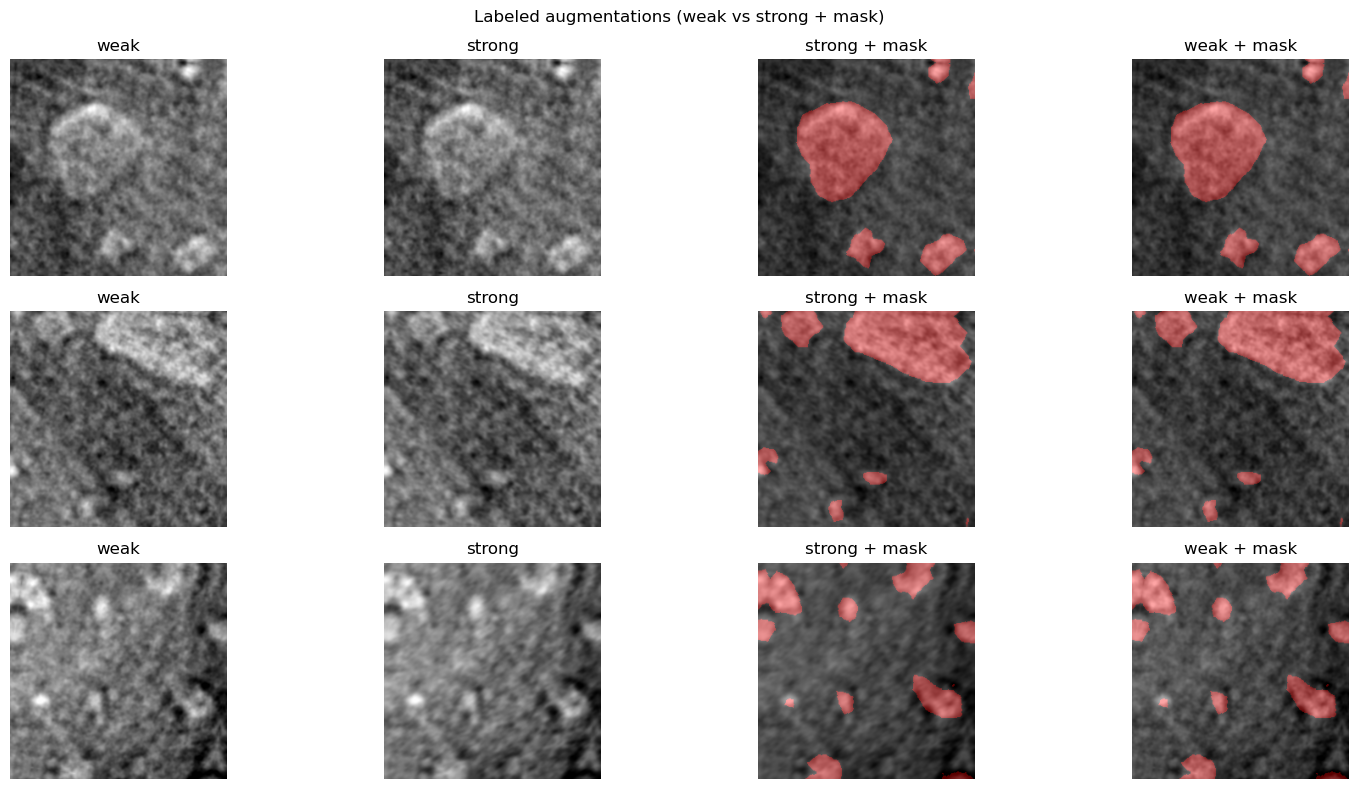

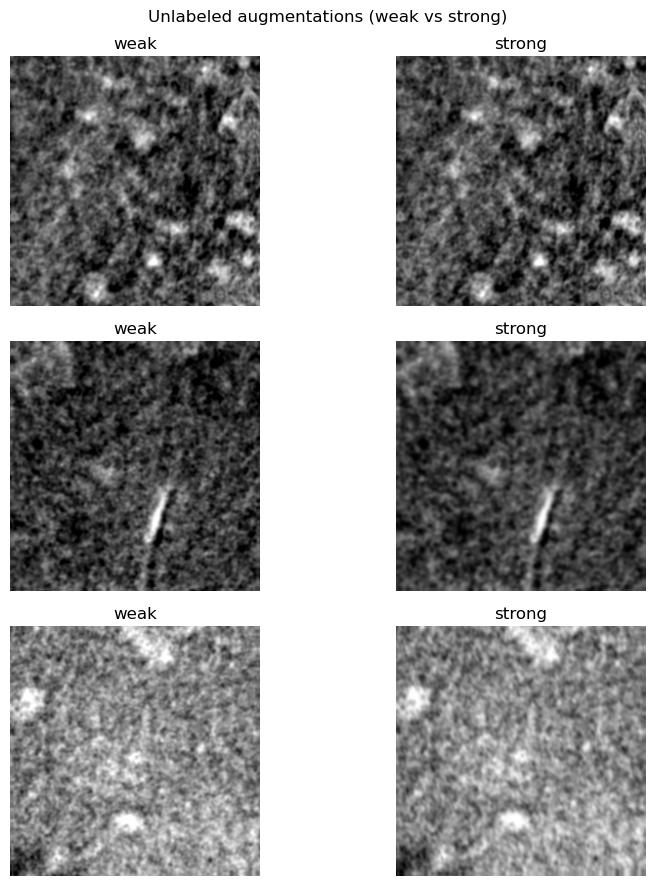

In [4]:

b_lab = next(iter(loaders["labeled"]))
b_unl = next(iter(loaders["unlabeled"]))
show_augmented_labeled(b_lab, n=3)
show_augmented_unlabeled(b_unl, n=3)


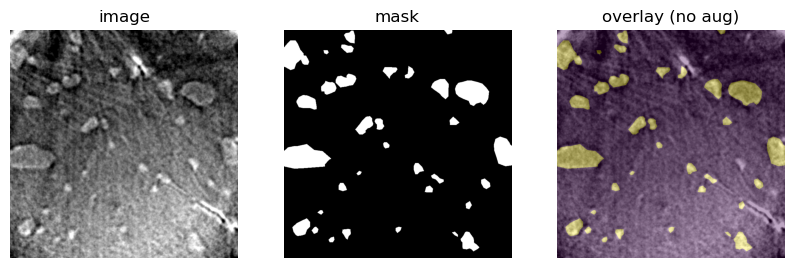

In [5]:
from pathlib import Path
from datasets import preprocess_pipeline

# Pick one known labeled pair
img_path  = Path(CFG["paths"]["labeled_dir"])/"Original_images"/"image_v2_00.tif"
mask_path = Path(CFG["paths"]["labeled_dir"])/"Original_masks"/"mask_000_inv.npy"  # or .png/.tif # or .tif/.png

ip, mp = preprocess_pipeline(img_path, mask_path, roi=None)  # NO ROI, NO AUG
img = np.array(ip, dtype=np.float32) / 255.0
msk = (np.array(mp) > 127).astype(np.float32)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray", vmin=0, vmax=1); plt.title("image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(msk, cmap="gray"); plt.title("mask"); plt.axis("off")
plt.subplot(1,3,3); 
plt.imshow(img, cmap="gray", vmin=0, vmax=1); plt.imshow(msk, alpha=0.35); 
plt.title("overlay (no aug)"); plt.axis("off")
plt.show()


In [6]:
# show which mask is being paired for the first few samples
ds = loaders["labeled"].dataset  # or rebuild loaders after editing
for k in range(3):
    rec = ds.samples[k]
    print("IMG:", rec["img"])
    print("MSK:", rec["mask"])


IMG: data/labeled/Original_images/image_v2_13.tif
MSK: data/labeled/Original_masks/mask_013_inv.npy
IMG: data/labeled/Original_images/image_v2_03.tif
MSK: data/labeled/Original_masks/mask_003_inv.npy
IMG: data/labeled/Original_images/image_v2_06.tif
MSK: data/labeled/Original_masks/mask_006_inv.npy


In [7]:
# --------------------- Supervised training on a UNET -----------------------
sup_model = UNet(1, 1).to(device)

opt = optim.AdamW(
    sup_model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="max", factor=0.5, patience=10, verbose=True, min_lr=1e-6
)

logger = CSVLogger(
    os.path.join(CFG["paths"]["run_dir"], "sup_metrics.csv"),
    ["epoch", "loss_sup", "val_dice", "val_iou"]
)

best_dice = -1.0
ckpt_sup  = os.path.join(CFG["paths"]["ckpt_dir"], "best_supervised.pth")
os.makedirs(os.path.join(CFG["paths"]["run_dir"], "images"), exist_ok=True)

for epoch in range(1, CFG["epochs_sup"] + 1):
    sup_model.train()
    run_loss = 0.0

    for b in loaders["labeled"]:
        x = b["x"].to(device) if "x" in b else b["x_s"].to(device)
        y = b["y"].to(device)
        logits = sup_model(x)
        loss   = combo_bce_dice(logits, y, w_bce=0.5)
        opt.zero_grad(); loss.backward(); opt.step()
        run_loss += float(loss.item())

    run_loss /= max(1, len(loaders["labeled"]))
    val_d, val_i = run_validation(sup_model, loaders["val"], device)
    logger.log([epoch, run_loss, val_d, val_i])
    scheduler.step(val_d)

    # print on each epoch
    print(f"[sup] epoch {epoch:03d} | train_loss={run_loss:.4f} | val_dice={val_d:.4f} | val_iou={val_i:.4f}")
    print(f"[sup] lr = {opt.param_groups[0]['lr']:.6g}")
     
    if epoch % 10 == 0:
        sup_model.eval()
        with torch.no_grad():
            vb  = next(iter(loaders["val"]))
            xx  = vb["x"].to(device)
            yy  = vb["y"].to(device)
            prb = torch.sigmoid(sup_model(xx))
            save_pred_grid(xx, yy, prb,
                os.path.join(CFG["paths"]["run_dir"], f"images/sup_epoch_{epoch}.png"))

    if val_d > best_dice:
        best_dice = val_d
        torch.save(sup_model.state_dict(), ckpt_sup)

logger.close()
print("Best supervised Dice:", best_dice)


/home/nmlre/anaconda3/envs/SegmentationDLProject/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[sup] epoch 001 | train_loss=0.7040 | val_dice=0.4073 | val_iou=0.2649
[sup] lr = 0.001
[sup] epoch 002 | train_loss=0.6045 | val_dice=0.4712 | val_iou=0.3232
[sup] lr = 0.001
[sup] epoch 003 | train_loss=0.5644 | val_dice=0.4343 | val_iou=0.2874
[sup] lr = 0.001
[sup] epoch 004 | train_loss=0.5328 | val_dice=0.4900 | val_iou=0.3422
[sup] lr = 0.001
[sup] epoch 005 | train_loss=0.4506 | val_dice=0.4617 | val_iou=0.3129
[sup] lr = 0.001
[sup] epoch 006 | train_loss=0.5960 | val_dice=0.5412 | val_iou=0.3812
[sup] lr = 0.001
[sup] epoch 007 | train_loss=0.5511 | val_dice=0.5467 | val_iou=0.3842
[sup] lr = 0.001
[sup] epoch 008 | train_loss=0.5338 | val_dice=0.5462 | val_iou=0.3857
[sup] lr = 0.001
[sup] epoch 009 | train_loss=0.4797 | val_dice=0.4775 | val_iou=0.3234
[sup] lr = 0.001
[sup] epoch 010 | train_loss=0.5092 | val_dice=0.4666 | val_iou=0.3141
[sup] lr = 0.001
[sup] epoch 011 | train_loss=0.4859 | val_dice=0.5694 | val_iou=0.4202
[sup] lr = 0.001
[sup] epoch 012 | train_loss=0.4

In [8]:
# --------------------- Semi-supervised (Mean-Teacher) now with freezed layers -----------------------
student = UNet(1, 1).to(device)
teacher = UNet(1, 1).to(device)

# init from best supervised weights
student.load_state_dict(torch.load(ckpt_sup, map_location=device))
teacher.load_state_dict(torch.load(ckpt_sup, map_location=device))
for p in teacher.parameters():
    p.requires_grad_(False)  # teacher is EMA only


# FREEZE: encoder blocks
for name, m in student.named_modules():
    if name.startswith(("down1","down2","down3")):  
        for p in m.parameters():
            p.requires_grad_(False)
        # if there are BN layers, keep running stats fixed
        m.eval()


opt_ssl = optim.AdamW(student.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

ssl_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt_ssl, mode="max", factor=0.5, patience=12, verbose=True, min_lr=1e-6
)

ema_momentum = CFG.get("ema_momentum", 0.99)            # e.g. 0.99–0.999
lambda_max   = CFG.get("consistency_weight", 1.0)        # weight for consistency term
ramp_epochs  = CFG.get("consistency_ramp_epochs", 10)    # ramp-up duration
epochs_ssl   = CFG.get("epochs_ssl", 40)

def ramp(t, T):
    """Cosine ramp 0->1 over T epochs."""
    if T <= 0: return 1.0
    x = np.clip(t / float(T), 0.0, 1.0)
    return float(0.5 - 0.5 * np.cos(np.pi * x))

mse = torch.nn.MSELoss()

# ---- logging & checkpoints ----
ssl_logger = CSVLogger(
    os.path.join(CFG["paths"]["run_dir"], "ssl_metrics.csv"),
    ["epoch", "loss_sup", "loss_consistency", "lam", "val_dice", "val_iou"],
)
ckpt_ssl_student = os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_student.pth")
ckpt_ssl_teacher = os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_teacher.pth")
best_ssl_dice = -1.0

def save_ssl_ckpts(student_model, teacher_model, epoch, val_dice):
    # rolling best
    torch.save(student_model.state_dict(), ckpt_ssl_student)
    torch.save(teacher_model.state_dict(), ckpt_ssl_teacher)
    # optional: epoch-tagged snapshots (handy for post-hoc inspection)
    tag = f"e{epoch:03d}_dice{val_dice:.3f}"
    torch.save(student_model.state_dict(), os.path.join(CFG["paths"]["ckpt_dir"], f"ssl_student_{tag}.pth"))
    torch.save(teacher_model.state_dict(), os.path.join(CFG["paths"]["ckpt_dir"], f"ssl_teacher_{tag}.pth"))

for epoch in range(1, epochs_ssl + 1):
    student.train(); teacher.eval()
    sup_run, cons_run, n_steps = 0.0, 0.0, 0

    lam = lambda_max * ramp(epoch, ramp_epochs)

    # persistent iterator over unlabeled
    unl_iter = iter(loaders["unlabeled"])

    for b_l in loaders["labeled"]:
        # ----- supervised step on labeled (use strong if available) -----
        xs = b_l["x_s"].to(device) if "x_s" in b_l else b_l["x"].to(device)
        y  = b_l["y"].to(device)

        s_logits = student(xs)
        loss_sup = combo_bce_dice(s_logits, y, w_bce=0.5)

        # ----- consistency on unlabeled (teacher weak vs student strong) -----
        try:
            b_u = next(unl_iter)
        except StopIteration:
            unl_iter = iter(loaders["unlabeled"])
            b_u = next(unl_iter)

        xw_u = b_u["x_w"].to(device) if "x_w" in b_u else b_u["x"].to(device)  # teacher (weak)
        xs_u = b_u["x_s"].to(device) if "x_s" in b_u else b_u["x"].to(device)  # student (strong)

        with torch.no_grad():
            t_logits = teacher(xw_u)
            t_probs  = torch.sigmoid(t_logits)  # soft targets

        s_logits_u = student(xs_u)
        s_probs_u  = torch.sigmoid(s_logits_u)

        loss_cons = mse(s_probs_u, t_probs)

        # ----- total loss & step -----
        loss_total = loss_sup + lam * loss_cons
        opt_ssl.zero_grad()
        loss_total.backward()
        opt_ssl.step()

        # ----- EMA update for teacher -----
        with torch.no_grad():
            m = ema_momentum
            for p_t, p_s in zip(teacher.parameters(), student.parameters()):
                p_t.data.mul_(m).add_(p_s.data, alpha=1.0 - m)

        sup_run  += float(loss_sup.item())
        cons_run += float(loss_cons.item())
        n_steps  += 1

    # epoch averages
    sup_run  /= max(1, n_steps)
    cons_run /= max(1, n_steps)

    # validation with student
    val_d, val_i = run_validation(student, loaders["val"], device)
    ssl_scheduler.step(val_d)
    print(f"[ssl] epoch {epoch:03d} | sup={sup_run:.4f} | cons={cons_run:.4f} | "
          f"lam={lam:.2f} | val_dice={val_d:.4f} | val_iou={val_i:.4f}")
    print(f"[ssl] lr = {opt_ssl.param_groups[0]['lr']:.6g}")

    # log row
    ssl_logger.log([epoch, sup_run, cons_run, lam, val_d, val_i])

    # keep best by validation Dice
    if val_d > best_ssl_dice:
        best_ssl_dice = val_d
        save_ssl_ckpts(student, teacher, epoch, val_d)

ssl_logger.close()
print(f"Best SSL student Dice: {best_ssl_dice:.4f}  (saved to {ckpt_ssl_student})")




/tmp/ipykernel_1592144/4077118897.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(ckpt_sup, map_location=device))
/tmp/ipykernel_15921

[ssl] epoch 001 | sup=0.3573 | cons=0.0529 | lam=0.02 | val_dice=0.5486 | val_iou=0.4041
[ssl] lr = 0.001
[ssl] epoch 002 | sup=0.3922 | cons=0.0342 | lam=0.10 | val_dice=0.7383 | val_iou=0.6117
[ssl] lr = 0.001
[ssl] epoch 003 | sup=0.2842 | cons=0.0173 | lam=0.21 | val_dice=0.7434 | val_iou=0.6352
[ssl] lr = 0.001
[ssl] epoch 004 | sup=0.3145 | cons=0.0239 | lam=0.35 | val_dice=0.6928 | val_iou=0.5720
[ssl] lr = 0.001
[ssl] epoch 005 | sup=0.3360 | cons=0.0246 | lam=0.50 | val_dice=0.6834 | val_iou=0.5527
[ssl] lr = 0.001
[ssl] epoch 006 | sup=0.2865 | cons=0.0171 | lam=0.65 | val_dice=0.7092 | val_iou=0.5761
[ssl] lr = 0.001
[ssl] epoch 007 | sup=0.3123 | cons=0.0102 | lam=0.79 | val_dice=0.7268 | val_iou=0.5976
[ssl] lr = 0.001
[ssl] epoch 008 | sup=0.3493 | cons=0.0099 | lam=0.90 | val_dice=0.7377 | val_iou=0.6131
[ssl] lr = 0.001
[ssl] epoch 009 | sup=0.2289 | cons=0.0087 | lam=0.98 | val_dice=0.7573 | val_iou=0.6411
[ssl] lr = 0.001
[ssl] epoch 010 | sup=0.2619 | cons=0.0082 | l

In [9]:
# ------- End-of-training evaluation (SSL) -------
# load best student checkpoint to be safe
ckpt_ssl = os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_student.pth")
student_eval = UNet(1,1).to(device)
student_eval.load_state_dict(torch.load(ckpt_ssl, map_location=device))
student_eval.eval()

# patch-level
ssl_test_d, ssl_test_i = run_validation(student_eval, loaders["test"], device)
print(f"[SSL TEST] Dice={ssl_test_d:.4f} | IoU={ssl_test_i:.4f}")

# full-ROI
ssl_full_d, ssl_full_i = eval_full_images(
    student_eval, loaders["test_full"],
    patch=CFG["patch_size"], overlap=0.5,
    device=device, dice_iou_fn=dice_iou_from_logits
)
print(f"[SSL FULL] Dice={ssl_full_d:.4f} | IoU={ssl_full_i:.4f}")

# (optional) also evaluate the teacher if you saved it
ckpt_teacher = os.path.join(CFG["paths"]["ckpt_dir"], "best_teacher.pth")
if os.path.exists(ckpt_teacher):
    teacher_eval = UNet(1,1).to(device)
    teacher_eval.load_state_dict(torch.load(ckpt_teacher, map_location=device))
    teacher_eval.eval()
    t_d, t_i = run_validation(teacher_eval, loaders["test"], device)
    print(f"[TEACHER TEST] Dice={t_d:.4f} | IoU={t_i:.4f}")


/tmp/ipykernel_1592144/2179706552.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_eval.load_state_dict(torch.load(ckpt_ssl, map_location=device))


[SSL TEST] Dice=0.7996 | IoU=0.6769
[SSL FULL] Dice=0.7205 | IoU=0.5682


Full-ROI — Dice 0.6016 | IoU 0.4302


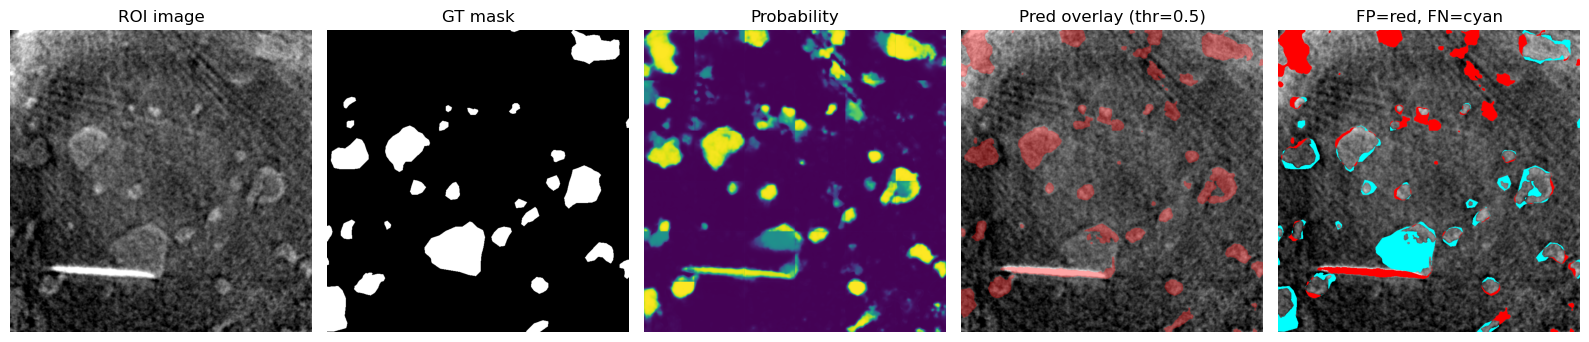

Full-ROI — Dice 0.8033 | IoU 0.6712


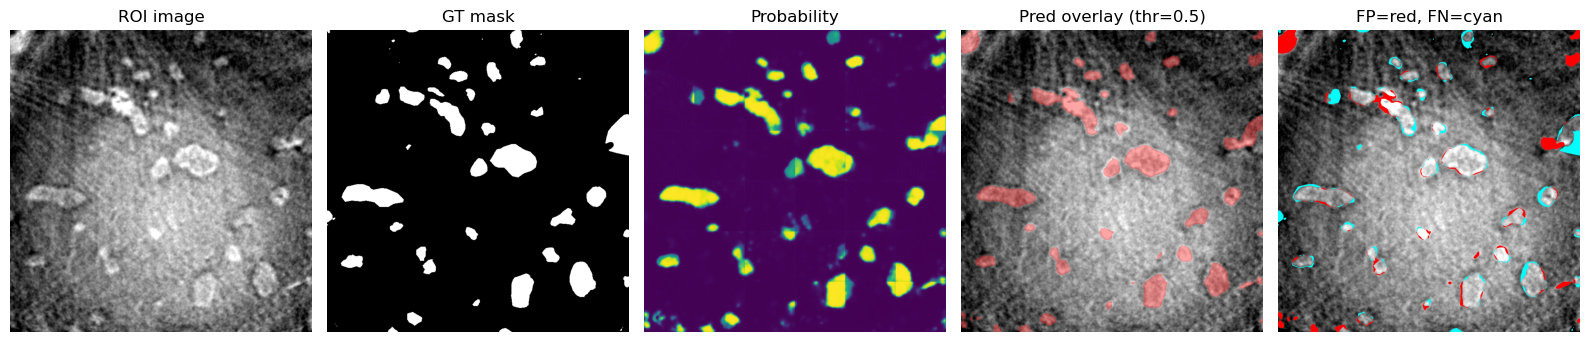

Full-ROI — Dice 0.7383 | IoU 0.5851


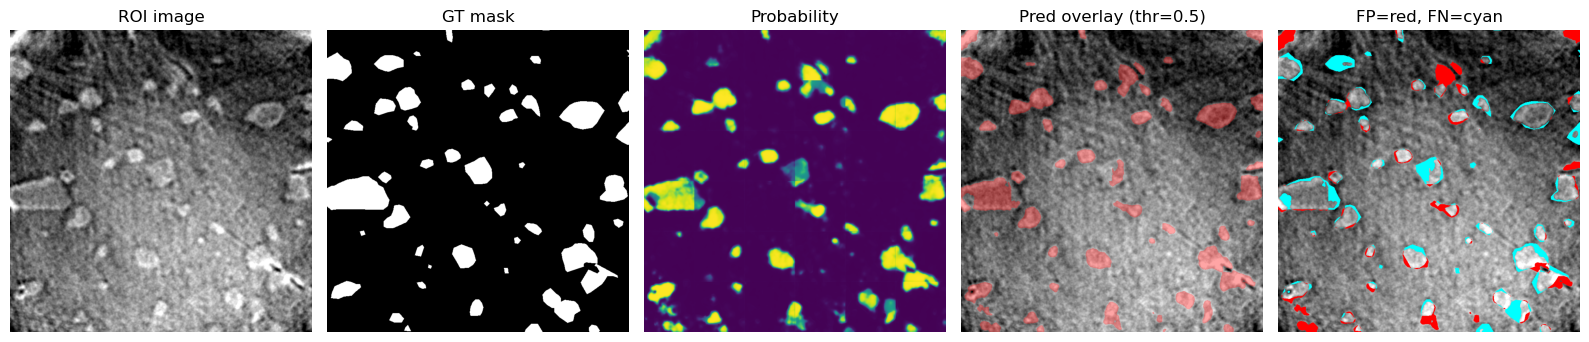

In [11]:
# show a few test images (full ROI, with GT overlays & Dice/IoU)
for i in range(3):   # change how many you want to view
    rec = loaders["test_full"].dataset.samples[i]
    plot_full_once(
        model,
        img_path=rec["img"],
        mask_path=rec["mask"],         # provides GT, so you get metrics & FP/FN map
        patch=CFG["patch_size"],
        overlap=0.5,
        device=device
    )


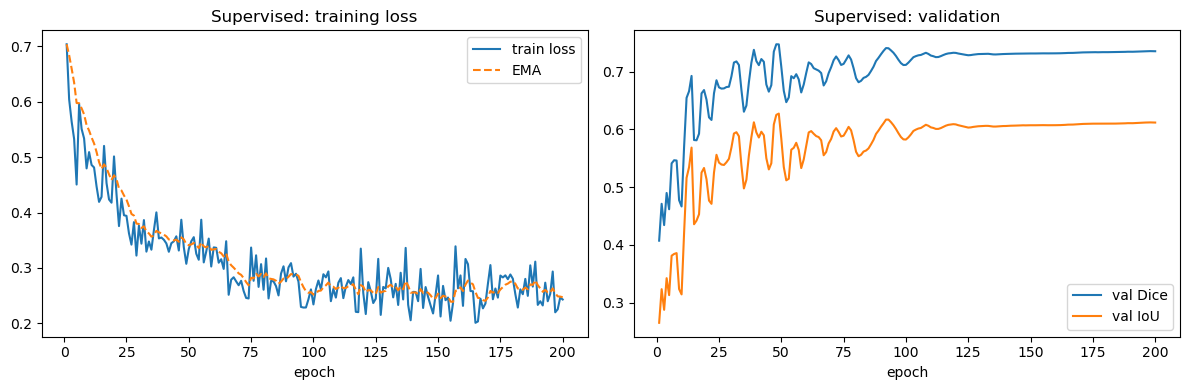

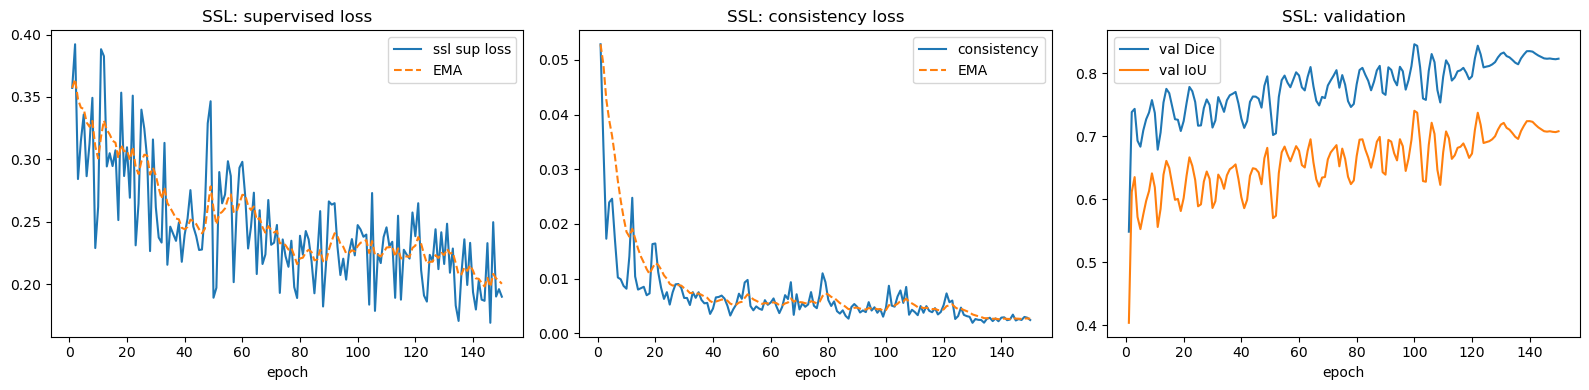

In [12]:
import os, pandas as pd, matplotlib.pyplot as plt

run_dir = CFG["paths"]["run_dir"]
sup_csv = os.path.join(run_dir, "sup_metrics.csv")
ssl_csv = os.path.join(run_dir, "ssl_metrics.csv")

def ema(x, alpha=0.2):
    if len(x) == 0: return x
    y = [x[0]]
    for v in x[1:]:
        y.append(alpha*v + (1-alpha)*y[-1])
    return y

# --- Supervised curves ---
if os.path.exists(sup_csv) and os.path.getsize(sup_csv) > 0:
    sup = pd.read_csv(sup_csv)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # loss
    ax[0].plot(sup.epoch, sup.loss_sup, label="train loss")
    ax[0].plot(sup.epoch, ema(sup.loss_sup.values), label="EMA", linestyle="--")
    ax[0].set_title("Supervised: training loss"); ax[0].set_xlabel("epoch"); ax[0].legend()
    # dice/iou
    ax[1].plot(sup.epoch, sup.val_dice, label="val Dice")
    ax[1].plot(sup.epoch, sup.val_iou,  label="val IoU")
    ax[1].set_title("Supervised: validation"); ax[1].set_xlabel("epoch"); ax[1].legend()
    plt.tight_layout(); plt.show()
else:
    print("No supervised CSV found or file is empty:", sup_csv)

# --- SSL curves ---
if os.path.exists(ssl_csv) and os.path.getsize(ssl_csv) > 0:
    ssl = pd.read_csv(ssl_csv)
    cols = [c for c in ["loss_sup","loss_consistency","lam","val_dice","val_iou"] if c in ssl.columns]
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    # supervised loss inside SSL
    if "loss_sup" in ssl:
        ax[0].plot(ssl.epoch, ssl.loss_sup, label="ssl sup loss")
        ax[0].plot(ssl.epoch, ema(ssl.loss_sup.values), label="EMA", linestyle="--")
        ax[0].set_title("SSL: supervised loss"); ax[0].set_xlabel("epoch"); ax[0].legend()
    # consistency loss
    if "loss_consistency" in ssl:
        ax[1].plot(ssl.epoch, ssl.loss_consistency, label="consistency")
        ax[1].plot(ssl.epoch, ema(ssl.loss_consistency.values), label="EMA", linestyle="--")
        ax[1].set_title("SSL: consistency loss"); ax[1].set_xlabel("epoch"); ax[1].legend()
    # val metrics
    if "val_dice" in ssl and "val_iou" in ssl:
        ax[2].plot(ssl.epoch, ssl.val_dice, label="val Dice")
        ax[2].plot(ssl.epoch, ssl.val_iou,  label="val IoU")
        ax[2].set_title("SSL: validation"); ax[2].set_xlabel("epoch"); ax[2].legend()
    plt.tight_layout(); plt.show()
else:
    print("No SSL CSV found or file is empty:", ssl_csv)


In [14]:

import importlib, utils_viz
importlib.reload(utils_viz)
from utils_viz import save_patch_vis_5panel


# Load best SSL student
ckpt_ssl = os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_student.pth")
ssl_model = UNet(1,1).to(device)
ssl_model.load_state_dict(torch.load(ckpt_ssl, map_location=device))
ssl_model.eval()

# Evaluate & visualize on patch-level test loader
out_dir = os.path.join(CFG["paths"]["run_dir"], "images_test_patches_ssl_5panel")
os.makedirs(out_dir, exist_ok=True)

dices, ious = [], []
saved = 0
max_grids = 6
thr = 0.5

with torch.no_grad():
    for b_idx, b in enumerate(loaders["test"]):
        x = b["x"].to(device)   # (B,1,256,256)
        y = b["y"].to(device)   # (B,1,256,256)
        logits = ssl_model(x)

        # metrics (per-batch average)
        d, i = dice_iou_from_logits(logits, y, thr=thr)
        dices.append(d); ious.append(i)

        # save a few 5-panel grids
        if saved < max_grids:
            prob = torch.sigmoid(logits)
            png = os.path.join(out_dir, f"ssl_test_patch_batch{b_idx:03d}.png")
            save_patch_vis_5panel(x, y, prob, png, thr=thr, max_rows=4)
            saved += 1

mean_dice = float(np.mean(dices)) if dices else 0.0
mean_iou  = float(np.mean(ious))  if ious  else 0.0
print(f"[SSL TEST PATCHES] mean Dice={mean_dice:.4f} | mean IoU={mean_iou:.4f} | batches={len(dices)}")


/tmp/ipykernel_1592144/192509374.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ssl_model.load_state_dict(torch.load(ckpt_ssl, map_location=device))


[SSL TEST PATCHES] mean Dice=0.7996 | mean IoU=0.6769 | batches=1


In [15]:
# After training supervised or by reloading best ckpt
ckpt_sup = os.path.join(CFG["paths"]["ckpt_dir"], "best_supervised.pth")
sup_model = UNet(1,1).to(device)
sup_model.load_state_dict(torch.load(ckpt_sup, map_location=device))
sup_model.eval()

out_dir_sup = os.path.join(CFG["paths"]["run_dir"], "images_test_patches_sup_5panel")
os.makedirs(out_dir_sup, exist_ok=True)

dices, ious = [], []; saved = 0
with torch.no_grad():
    for b_idx, b in enumerate(loaders["test"]):
        x = b["x"].to(device); y = b["y"].to(device)
        logits = sup_model(x)
        d, i = dice_iou_from_logits(logits, y, thr=0.5)
        dices.append(d); ious.append(i)
        if saved < 6:
            prob = torch.sigmoid(logits)
            png = os.path.join(out_dir_sup, f"sup_test_patch_batch{b_idx:03d}.png")
            save_patch_vis_5panel(x, y, prob, png, thr=0.5, max_rows=4)
            saved += 1

print(f"[SUP TEST PATCHES] mean Dice={np.mean(dices):.4f} | mean IoU={np.mean(ious):.4f}")


/tmp/ipykernel_1592144/4230249814.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sup_model.load_state_dict(torch.load(ckpt_sup, map_location=device))


[SUP TEST PATCHES] mean Dice=0.7354 | mean IoU=0.5945
